# Лабораторная работа №1 по дисциплине "Основы машинного обучения"

Выполнили cтуденты группы 3311:
- Шарпинский Денис
- Локтионов Тимофей
- Суздалева Алёна

Требования:
- Число столбцов признаков – 10 и более.
- Число записей – не менее 10000.
- Набор данных имеет пропуски.

Задачи:
- Очистка данных (удаление пропусков, нормализация, удаление дубликатов).
- Визуализация значимых признаков.
- диаграммы рассеяния.
- ящики с усами.
- гистограммы.
- Корреляция данных (матрица корреляций и статистический анализ).

Датасет: https://www.kaggle.com/datasets/adilshamim8/exploring-mental-health-data/code.

В датасете 140700 строк и 20 признаков.

# Импорты

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Константы

In [2]:
URL_TRAIN = "https://raw.githubusercontent.com/Pyc-Nya/year3/main/sem5/ai/train.csv"
URL_TEST = "https://raw.githubusercontent.com/Pyc-Nya/year3/main/sem5/ai/test.csv"
TARGET_COL = "Depression"
RANDOM_STATE=5

# Чтение данных

In [3]:
def load_data(url):
    return pd.read_csv(url)

df_train_raw = load_data(URL_TRAIN)
df_test_raw = load_data(URL_TEST)

print(f"Train: {df_train_raw.shape}")
print(f"Test: {df_test_raw.shape}")

Train: (140700, 20)
Test: (93800, 19)


# Общая информация

In [4]:
print("\n=== СТРУКТУРА ДАТАСЕТА ===")
print(f"Всего столбцов: {len(df_train_raw.columns)}")

print("\n=== ТИПЫ ДАННЫХ ===")
print(df_train_raw.dtypes)

print("\n=== БАЗОВАЯ СТАТИСТИКА ===")
print(df_train_raw.describe())

print("\n=== ПЕРВЫЕ 5 СТРОК ===")
print(df_train_raw.head())

print("\n=== Вывод количества ненулевых значений ===")
print(df_train_raw.info())


=== СТРУКТУРА ДАТАСЕТА ===
Всего столбцов: 20

=== ТИПЫ ДАННЫХ ===
id                                         int64
Name                                      object
Gender                                    object
Age                                      float64
City                                      object
Working Professional or Student           object
Profession                                object
Academic Pressure                        float64
Work Pressure                            float64
CGPA                                     float64
Study Satisfaction                       float64
Job Satisfaction                         float64
Sleep Duration                            object
Dietary Habits                            object
Degree                                    object
Have you ever had suicidal thoughts ?     object
Work/Study Hours                         float64
Financial Stress                         float64
Family History of Mental Illness          object
D

# Функция анализа данных

В последующих секциях мы проводим анализ данных. Представлены функции для:
1. Анализа категориальных данных
2. Анализа пропусков
3. Анализа баланса классов
4. Поиск порогового значения для последующей обработки, эта функция будет использоваться далее, но идеологически она является аналитической функцией, поэтому расположена здесь. Разберём её отдельно.

Для обработки городов и уровня образования было необходимо произвести обобщение данных из сотни возможных вариантов получить, скажем, 30.

Рассмотрим на примере городов. Мы формируем частотный словарь, а именно, сколько человек приходится на тот или иной город. Затем функция перебирает возможные пороговые значения (от большего к меньшему) и для каждого порога проверяет:
   - Сколько групп (городов) останется, если оставить только те, где количество людей >= порога
   - Какой процент данных будет покрыт этими группами
   
Функция возвращает первый порог, который удовлетворяет двум условиям:
   - Покрытие данных >= `min_coverage` (например, 80%)
   - Количество групп >= `min_groups` (например, 10)
   
Это позволяет сбалансировать детализацию данных и их обобщение: мы сохраняем достаточно групп для анализа, но при этом покрываем большую часть выборки, избегая чрезмерной фрагментации на редкие категории.

In [5]:
def analyze_categorical_columns(df):
    """Показывает все уникальные значения для категориальных столбцов"""

    # Выбираем только категориальные столбцы (object)
    categorical_cols = df.select_dtypes(include=['object']).columns

    print(f"=== КАТЕГОРИАЛЬНЫЕ СТОЛБЦЫ ({len(categorical_cols)}) ===\n")

    for col in categorical_cols:
        unique_count = df[col].nunique()
        missing = df[col].isnull().sum()

        print(f"- {col}")
        print(f"   Уникальных: {unique_count}, Пропусков: {missing}")

        # Если значений мало — показываем все
        if unique_count <= 10:
            print(f"   Значения: {df[col].unique().tolist()}")
        else:
            # Если много — показываем топ-5
            top5 = df[col].value_counts().head(5)
            print(f"   Топ-5: {top5.to_dict()}")

        print()

def analyze_missing(df):
    missing_percent = (df.isnull().sum() / len(df)) * 100
    return missing_percent[missing_percent > 0]

def analyze_class_balance(df, target):
    counts = df[target].value_counts()
    print(f"Класс 0: {counts[0]} ({counts[0]/len(df)*100:.1f}%)")
    print(f"Класс 1: {counts[1]} ({counts[1]/len(df)*100:.1f}%)")

def find_optimal_threshold(df, column_name, min_coverage, min_groups):
    group_sizes = df[column_name].value_counts().sort_values(ascending=False)
    total = len(df)
    possible_thresholds = sorted(group_sizes.unique(), reverse=True)

    for threshold in possible_thresholds:
        count = (group_sizes >= threshold).sum()
        people_covered = group_sizes[group_sizes >= threshold].sum()
        percent = (people_covered / total) * 100

        if percent >= min_coverage and count >= min_groups:
            print(f"\nОптимальный порог для {column_name}: {threshold}")
            print(f"  Групп: {count}, Покрытие: {percent:.1f}%")
            return threshold

    default = 50
    print(f"\n Используется порог по умолчанию: {default}")
    return default

# Анализ

In [6]:
print("\n" + "="*60)
print("АНАЛИЗ ПРИЗНАКОВ")
print("="*60)

# Категориальные столбцы
print("\nКАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ:")
categorical_cols = df_train_raw.select_dtypes(include=['object']).columns
for col in categorical_cols:
    unique = df_train_raw[col].nunique()
    missing_pct = df_train_raw[col].isnull().sum() / len(df_train_raw) * 100
    print(f"  - {col}: {unique} значений, {missing_pct:.1f}% пропусков")

# Числовые столбцы
print("\nЧИСЛОВЫЕ ПРИЗНАКИ:")
numeric_cols = df_train_raw.select_dtypes(include=[np.number]).columns
print(f"  Всего: {len(numeric_cols)}")

print("\n" + "="*60)
print("РЕШЕНИЯ ПО ОБРАБОТКЕ")
print("="*60)

# === CGPA ===
print("\n CGPA vs ДЕПРЕССИЯ (студенты):")
students = df_train_raw[df_train_raw['CGPA'].notna()]
correlation = students['CGPA'].corr(students['Depression'])
cgpa_no_dep = students[students['Depression'] == 0]['CGPA'].mean()
cgpa_with_dep = students[students['Depression'] == 1]['CGPA'].mean()
print(f"  Корреляция: {correlation:.4f}")
print(f"  Средний CGPA без депрессии: {cgpa_no_dep:.2f}")
print(f"  Средний CGPA с депрессией: {cgpa_with_dep:.2f}")
print(f"  Вывод: слабая связь -> УДАЛЯЕМ")

# === РАБОТА + УЧЕБА одновременно ===
print("\n ПРОВЕРКА: работа + учеба одновременно")
both = (df_train_raw['Academic Pressure'].notna() & df_train_raw['Work Pressure'].notna()).sum()
total = len(df_train_raw)
print(f"  Людей с обоими значениями: {both} из {total} ({both/total*100:.1f}%)")
print(f"  Вывод: идеальное дополнение -> ОБЪЕДИНЯЕМ")

# === DEGREE ===
print("\n ОБРАЗОВАНИЕ vs ДЕПРЕССИЯ:")
degree_stats = df_train_raw[df_train_raw['Degree'].notna()].groupby('Degree')['Depression'].agg(['count', 'mean']).reset_index()
degree_stats.columns = ['Degree', 'total', 'depression_rate']
degree_stats = degree_stats[degree_stats['total'] >= 100]
degree_stats = degree_stats.sort_values('depression_rate', ascending=False)

print(f"  Топ-3 с наибольшей депрессией:")
for _, row in degree_stats.head(3).iterrows():
    print(f"    - {row['Degree']}: {row['depression_rate']*100:.1f}% (n={row['total']})")

print(f"  Разброс: {degree_stats['depression_rate'].min()*100:.1f}% - {degree_stats['depression_rate'].max()*100:.1f}%")
print(f"  СКО: {degree_stats['depression_rate'].std():.3f}")
degree_threshold = find_optimal_threshold(df_train_raw, 'Degree', min_coverage=99, min_groups=20)
print(f"  Вывод: сильная связь -> КОДИРУЕМ (порог {degree_threshold})")

# Пропуски
print("\n УДАЛЯЕМ:")
print("  - id, Name - технические")
print(f"  - CGPA - корреляция {correlation:.2f}, только у студентов (20%)")
print("  - Profession - СКО 0.032, 26% пропусков")
print("  - City - разброс 12.6%-27.5%, нет гарантии совпадения с test")

# Объединяем
print("\n ОБЪЕДИНЯЕМ:")
print("  - Academic/Work Pressure -> Pressure")
print("  - Study/Job Satisfaction -> Satisfaction")

# Очищаем
print("\n ОЧИЩАЕМ ОТ МУСОРА:")
diet_clean = df_train_raw[df_train_raw['Dietary Habits'].isin(['Healthy', 'Moderate', 'Unhealthy'])]
diet_stats = diet_clean.groupby('Dietary Habits')['Depression'].mean()
print(f"  - Dietary Habits: 3 валидных из 23")
print(f"    Unhealthy: {diet_stats['Unhealthy']*100:.1f}%, Moderate: {diet_stats['Moderate']*100:.1f}%, Healthy: {diet_stats['Healthy']*100:.1f}%")

valid_sleep = ['Less than 5 hours', '5-6 hours', '7-8 hours', 'More than 8 hours']
sleep_clean = df_train_raw[df_train_raw['Sleep Duration'].isin(valid_sleep)]
sleep_stats = sleep_clean.groupby('Sleep Duration')['Depression'].mean()
print(f"  - Sleep Duration: 4 валидных из 36, СКО {sleep_stats.std():.3f}")

# Преобразуем
print("\n ПРЕОБРАЗУЕМ:")
print("  - Sleep Duration -> Sleep_Hours (4, 5.5, 7.5, 9)")
print("  - Dietary Habits -> числа (0, 1, 2)")
print("  - Gender, Suicidal Thoughts, Family History -> бинарные (0/1)")

# Баланс классов
print("\n БАЛАНС КЛАССОВ:")
analyze_class_balance(df_train_raw, TARGET_COL)

print("\n" + "="*60)


АНАЛИЗ ПРИЗНАКОВ

КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ:
  - Name: 422 значений, 0.0% пропусков
  - Gender: 2 значений, 0.0% пропусков
  - City: 98 значений, 0.0% пропусков
  - Working Professional or Student: 2 значений, 0.0% пропусков
  - Profession: 64 значений, 26.0% пропусков
  - Sleep Duration: 36 значений, 0.0% пропусков
  - Dietary Habits: 23 значений, 0.0% пропусков
  - Degree: 115 значений, 0.0% пропусков
  - Have you ever had suicidal thoughts ?: 2 значений, 0.0% пропусков
  - Family History of Mental Illness: 2 значений, 0.0% пропусков

ЧИСЛОВЫЕ ПРИЗНАКИ:
  Всего: 10

РЕШЕНИЯ ПО ОБРАБОТКЕ

 CGPA vs ДЕПРЕССИЯ (студенты):
  Корреляция: 0.0217
  Средний CGPA без депрессии: 7.62
  Средний CGPA с депрессией: 7.69
  Вывод: слабая связь -> УДАЛЯЕМ

 ПРОВЕРКА: работа + учеба одновременно
  Людей с обоими значениями: 0 из 140700 (0.0%)
  Вывод: идеальное дополнение -> ОБЪЕДИНЯЕМ

 ОБРАЗОВАНИЕ vs ДЕПРЕССИЯ:
  Топ-3 с наибольшей депрессией:
    - Class 12: 51.3% (n=14729)
    - B.Tech: 21.4% (n=44

После анализа данных по каждому отдельному столбцу, были приняты следующие решения:
1. Удаление столбцов id, name, т к они не несут существенной информации по теме.
2. Удаление столбца CGPA (успеваемость) по причине низкой корреляции с целевым столбцом, а также этот параметр присутствует только у студентов, которых лишь 20% от общего числа опрошенных.
3. Удалить столбец City, поскольку
   - Нет гарантии, что в тестовых данных будут такие же города.
   - Была предпринята попытка преобразовать данные, для каждого города, количество опрошенных в котором превосходило пороговое значение, мы высчитывали `depression_rate`, для городов, где было опрошено меньшее количество людей (в случае с нашим датасетом - это зачастую от 0 до 5), мы брали среднее значение. Было получено суммарно 30 групп и одна - города с количеством опрошенных меньше порогового значения. В результате стало понятно, что самый "депрессивный" город имеет `depression_rate` лишь 25%, а наименнее депрессивный 17%, что, во-первых, небольшой разброс, а во вторых не так существенно, как, например, возраст или давление от общества. В результате мы решили избавиться от этого столбца.
4. Объединить столбцы `Work pressure` и `Academic pressure`
   - Мы выяснили, что нет людей, которые работают и учатся одновременно или не работают и не учатся одновременно, то есть данные идеально дополняют друг друга, так что логично их объединить.
5. Объединить `Satisfaction`-столбцы по причине, аналогичной из пункта 4.
6. Удалить столбец `Profession` - чересчур много профессий, много пропусков, и из-за слишком малой выборки людей, работающих на конкретной профессии, нельзя однозначно строить выводы о корреляции депрессии и профессии.
7. Преобразовать Degree в Degree_rate. Была выявлена сильная корреляция между уровнем образования и депрессией (половина школьников имеют депрессию), поэтому мы решили оставить этот столбец. С ним была проделана та же работа, что и с городами.
8. Преобразовали `Dietary Habits`, большая часть столбцов принимала ровно 3 значения: `Healthy`, `Moderate`, `Unhealthy`, поэтому мы оставили только эти три, остальные заменив на моду. Впоследствии также заменили строки на числа - 0, 1, 2.
9. `Sleep Duration` был довольно хаотичным столбцом, но ситуация, отчасти, повторялась как с `Dietary Habits`, а также, поскольку это фактически числовой параметр, то мы просто распределили продолжительность сна по 4ём самым популярным группам, в которые входило 99% опрошенных.

# Визуализация


=== ВИЗУАЛИЗАЦИЯ ===


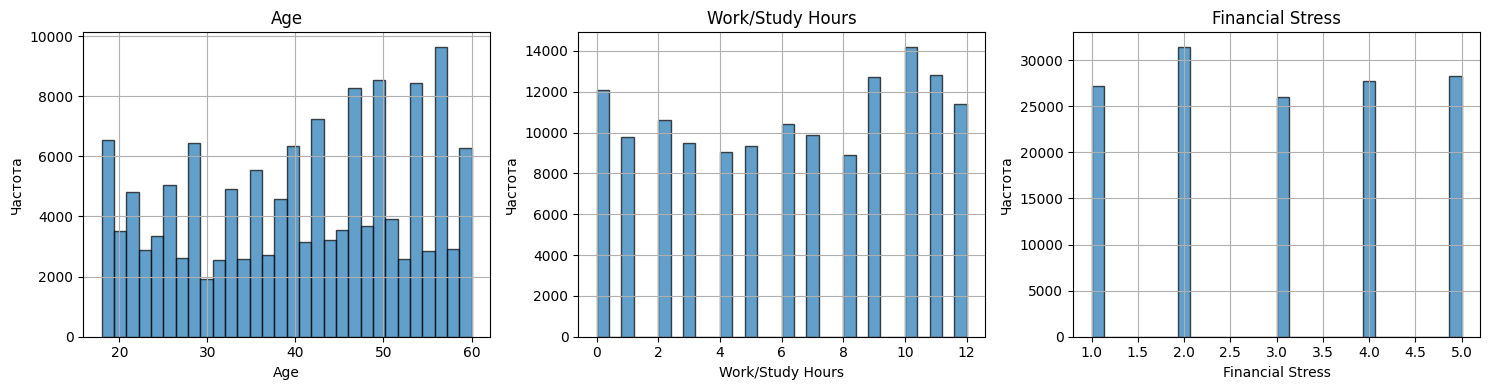

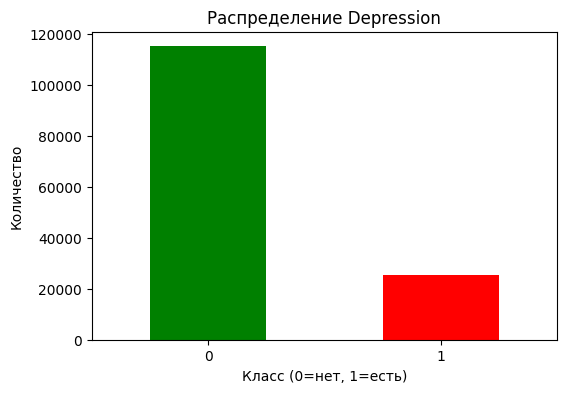

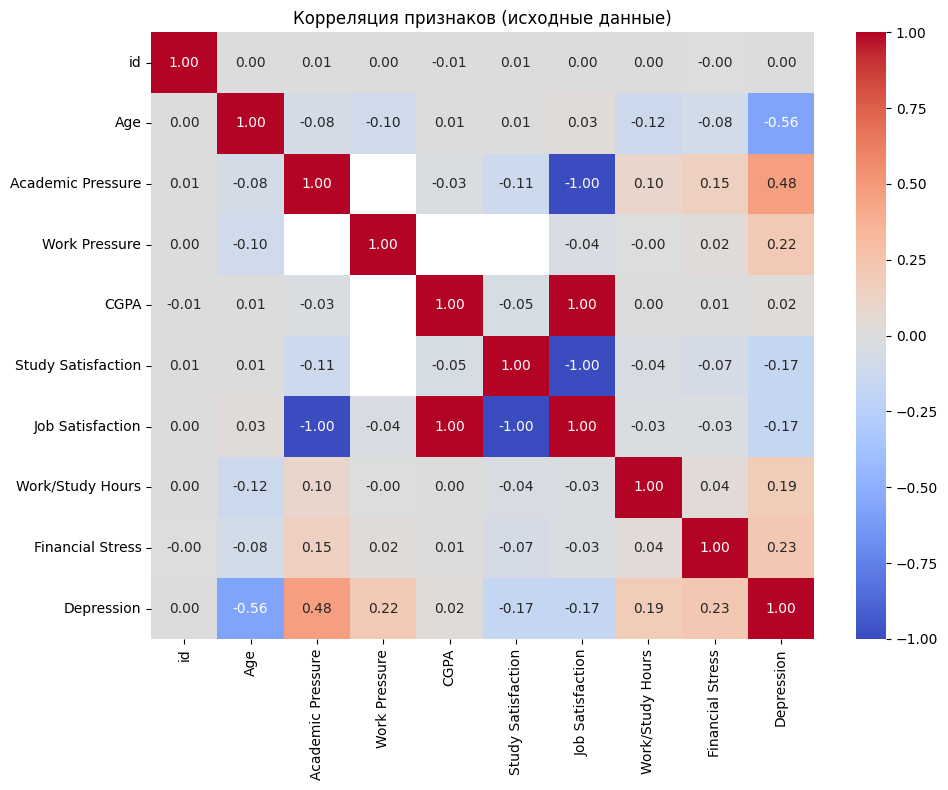

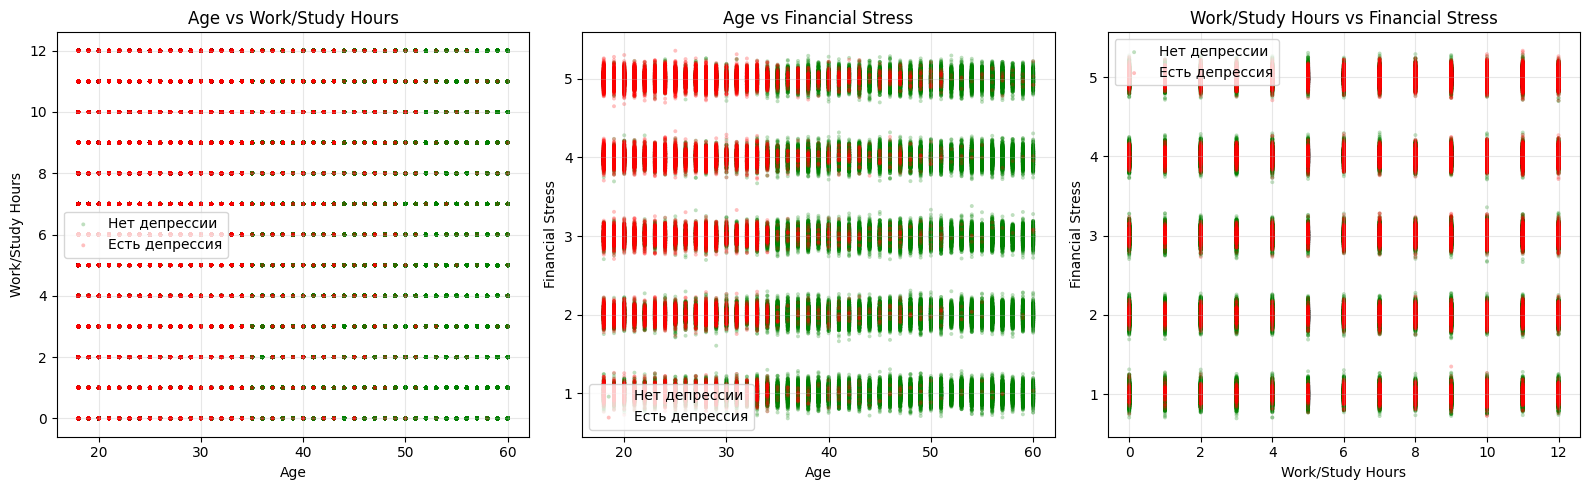

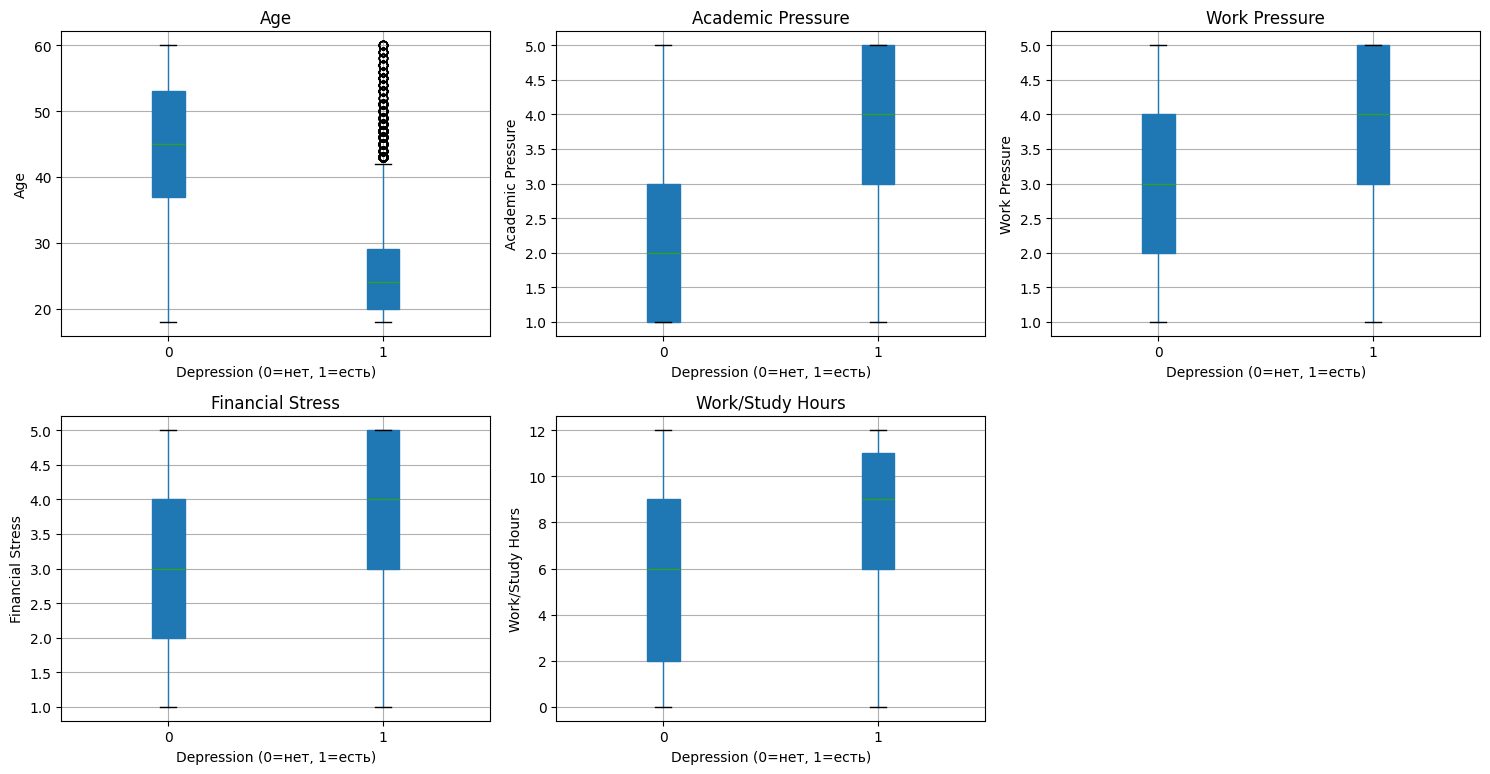

In [7]:
print("\n=== ВИЗУАЛИЗАЦИЯ ===")

# 1. РАСПРЕДЕЛЕНИЕ ЧИСЛОВЫХ ПРИЗНАКОВ (гистограммы)
numeric_cols = ['Age', 'Work/Study Hours', 'Financial Stress']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, col in enumerate(numeric_cols):
    df_train_raw[col].hist(bins=30, ax=axes[i], edgecolor='black', alpha=0.7)
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Частота')
plt.tight_layout()
plt.show()

# 2. БАЛАНС КЛАССОВ
plt.figure(figsize=(6, 4))
df_train_raw['Depression'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Распределение Depression')
plt.xlabel('Класс (0=нет, 1=есть)')
plt.ylabel('Количество')
plt.xticks(rotation=0)
plt.show()

# 3. КОРРЕЛЯЦИОННАЯ МАТРИЦА (только исходные числовые)
numeric_data = df_train_raw.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data.corr(), annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Корреляция признаков (исходные данные)')
plt.tight_layout()
plt.show()

pairs = [
    ('Age', 'Work/Study Hours'),
    ('Age', 'Financial Stress'),
    ('Work/Study Hours', 'Financial Stress'),
]

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i, (x, y) in enumerate(pairs):
    mask = df_train_raw[x].notna() & df_train_raw[y].notna()
    plot_data = df_train_raw[mask]

    # Разделяем по классам
    no_dep = plot_data[plot_data['Depression'] == 0]
    with_dep = plot_data[plot_data['Depression'] == 1]

    # Добавляем jitter для дискретных признаков
    y_no = no_dep[y] + np.random.normal(0, 0.08, len(no_dep)) if y == 'Financial Stress' else no_dep[y]
    y_with = with_dep[y] + np.random.normal(0, 0.08, len(with_dep)) if y == 'Financial Stress' else with_dep[y]

    axes[i].scatter(no_dep[x], y_no, alpha=0.25, s=8, c='green', label='Нет депрессии', edgecolors='none')
    axes[i].scatter(with_dep[x], y_with, alpha=0.25, s=8, c='red', label='Есть депрессия', edgecolors='none')

    axes[i].set_xlabel(x)
    axes[i].set_ylabel(y)
    axes[i].set_title(f'{x} vs {y}')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. ЯЩИКИ С УСАМИ (Box plots)
# Создаем временный датасет с объединенными признаками
features_box = ['Age', 'Academic Pressure', 'Work Pressure',
                'Financial Stress', 'Work/Study Hours']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(features_box):
    # Фильтруем NaN для столбцов с пропусками
    plot_data = df_train_raw[[col, 'Depression']].dropna()

    plot_data.boxplot(column=col, by='Depression', ax=axes[i], patch_artist=True)
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('Depression (0=нет, 1=есть)')
    axes[i].set_ylabel(col)
    axes[i].get_figure().suptitle('')

# Удаляем лишний subplot
axes[-1].remove()

plt.tight_layout()
plt.show()

# Функции обработки данных

Здесь описаны функции обработки данных, которые косвенно были упомянуты в пояснении к анализу данных.

Особую важность здесь имеют две последние функции. Как и было сказано ранее, для уровня образования мы строим map, где ставим в соответствие уровень образования и `depression_rate`.

Но, поскольку часть данных является мусорными или незначительными (99% опрошенных входят в 28 групп из доступных 50 вариантов образования), то мы определили пороговое значение, начиная с которого мы вместо актуального значения подставляем среднее по всем опрошенным.

Также, стоит отметить, что в тестовых данных поля `Depression`, очевидно, нет, поэтому мы не сможем произвести такие же вычисления для тестовых данных. Но нам и не нужно, поскольку мы можем использовать статистику, взятую из тренировочных. Поэтому мы и формируем `encoding_map`, в которой ставится в соответствие степень образования и % депрессии.

Последняя функция просто применяет эту map и вычисленное среднее значение к конкретному фрему.

In [8]:
def combine_pressure_satisfaction(df):
    df = df.copy()
    df['Pressure'] = df['Academic Pressure'].fillna(df['Work Pressure'])
    df['Satisfaction'] = df['Study Satisfaction'].fillna(df['Job Satisfaction'])
    return df

def clean_dietary_habits(df):
    df = df.copy()
    valid_values = ['Healthy', 'Moderate', 'Unhealthy']
    df['Dietary_Habits'] = df['Dietary Habits'].apply(lambda x: x if x in valid_values else None)
    mode_value = df['Dietary_Habits'].mode()[0]
    df['Dietary_Habits'] = df['Dietary_Habits'].fillna(mode_value)
    return df

def clean_and_convert_sleep(df):
    """Очищает Sleep Duration и преобразует в числа"""
    df = df.copy()

    # Маппинг валидных значений на средние часы
    sleep_mapping = {
        'Less than 5 hours': 4,
        '5-6 hours': 5.5,
        '7-8 hours': 7.5,
        'More than 8 hours': 9
    }

    # Преобразуем
    df['Sleep_Hours'] = df['Sleep Duration'].map(sleep_mapping)

    # Мусорные значения -> заполняем медианой (7.5 часов)
    mean_sleep = df['Sleep_Hours'].mean()  # будет 7.5
    df['Sleep_Hours'] = df['Sleep_Hours'].fillna(mean_sleep)

    return df

def encode_binary_categorical(df):
    """Преобразует бинарные категории в 0/1"""
    df = df.copy()

    # Gender: Female=0, Male=1
    df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1})

    # Suicidal thoughts: No=0, Yes=1
    df['Suicidal_Thoughts'] = df['Have you ever had suicidal thoughts ?'].map({'No': 0, 'Yes': 1})

    # Family history: No=0, Yes=1
    df['Family_History'] = df['Family History of Mental Illness'].map({'No': 0, 'Yes': 1})

    return df

def fill_financial_stress(df):
    """Заполняет пропуски в Financial Stress медианой"""
    df = df.copy()
    mean_value = df['Financial Stress'].mean()
    df['Financial Stress'] = df['Financial Stress'].fillna(mean_value)
    return df

def fill_pressure_satisfaction(df):
    """Заполняет оставшиеся пропуски в Pressure и Satisfaction медианой"""
    df = df.copy()
    df['Pressure'] = df['Pressure'].fillna(df['Pressure'].mean())
    df['Satisfaction'] = df['Satisfaction'].fillna(df['Satisfaction'].mean())
    return df

def encode_dietary_ordinal(df):
    df = df.copy()
    mapping = {'Healthy': 0, 'Moderate': 1, 'Unhealthy': 2}
    df['Dietary_Habits'] = df['Dietary_Habits'].map(mapping)
    return df

def calculate_degree_encoding_map(df_train, min_coverage=99, min_groups=20):
    """
    Вычисляет словарь: степень -> % депрессии
    Возвращает (degree_rates, overall_mean)
    """
    # Находим порог
    degree_threshold = find_optimal_threshold(df_train, 'Degree', min_coverage, min_groups)

    # Фильтруем крупные степени
    degree_counts = df_train.groupby('Degree').size()
    large_degrees = degree_counts[degree_counts >= degree_threshold].index

    # Вычисляем % депрессии для них
    degree_rates = df_train[df_train['Degree'].isin(large_degrees)].groupby('Degree')['Depression'].mean()

    # Общее среднее для редких
    overall_mean = df_train['Depression'].mean()

    return degree_rates, overall_mean

def apply_degree_encoding(df, degree_rates, overall_mean):
    """Применяет готовый словарь кодирования"""
    df = df.copy()
    df['Degree_Depression_Rate'] = df['Degree'].map(degree_rates).fillna(overall_mean)
    return df

# Тесты обработки

In [9]:
print("\n=== ТЕСТЫ ФУНКЦИЙ ===")

df_test1 = combine_pressure_satisfaction(df_train_raw)
df_test2 = fill_pressure_satisfaction(df_test1)
print(f"1. Pressure/Satisfaction: {df_test2[['Pressure', 'Satisfaction']].isnull().sum().sum()} пропусков")

df_test3 = clean_dietary_habits(df_test2)
df_test4 = encode_dietary_ordinal(df_test3)
print(f"2. Dietary_Habits: {sorted(df_test4['Dietary_Habits'].unique())}")

df_test5 = clean_and_convert_sleep(df_test4)
print(f"3. Sleep_Hours: {sorted(df_test5['Sleep_Hours'].unique())}")

df_test6 = encode_binary_categorical(df_test5)
print(f"4. Binary кодирование: ")

df_test7 = fill_financial_stress(df_test6)
print(f"5. Financial Stress: {df_test7['Financial Stress'].isnull().sum()} пропусков")

print(f"\n Всего пропусков: {df_test7.isnull().sum().sum()}")

print("\n=== ТЕСТ: calculate_degree_encoding_map ===")
degree_rates, overall_mean = calculate_degree_encoding_map(df_train_raw)
print(f"Крупных степеней: {len(degree_rates)}")
print(f"Общее среднее: {overall_mean:.4f}")
print(f"\nПримеры маппинга:")
print(degree_rates.head())

print("\n=== ТЕСТ: apply_degree_encoding ===")
df_test_degree = apply_degree_encoding(df_train_raw, degree_rates, overall_mean)
print(f"Создан Degree_Depression_Rate: {df_test_degree['Degree_Depression_Rate'].isnull().sum()} пропусков")
print(f"Пример значений: {df_test_degree['Degree_Depression_Rate'].head().tolist()}")


=== ТЕСТЫ ФУНКЦИЙ ===
1. Pressure/Satisfaction: 0 пропусков
2. Dietary_Habits: [np.int64(0), np.int64(1), np.int64(2)]
3. Sleep_Hours: [np.float64(4.0), np.float64(5.5), np.float64(6.426625468457769), np.float64(7.5), np.float64(9.0)]
4. Binary кодирование: 
5. Financial Stress: 0 пропусков

 Всего пропусков: 430872

=== ТЕСТ: calculate_degree_encoding_map ===

Оптимальный порог для Degree: 2887
  Групп: 27, Покрытие: 99.9%
Крупных степеней: 27
Общее среднее: 0.1817

Примеры маппинга:
Degree
B.Arch     0.157515
B.Com      0.155676
B.Ed       0.128732
B.Pharm    0.119194
B.Tech     0.214011
Name: Depression, dtype: float64

=== ТЕСТ: apply_degree_encoding ===
Создан Degree_Depression_Rate: 0 пропусков
Пример значений: [0.17259001161440185, 0.15064397424103035, 0.11919398907103824, 0.13439363817097416, 0.13439363817097416]


# Финальная обработка

In [10]:
def preprocess_train_test(df_train, df_test):
    df_train = df_train.copy()
    df_test = df_test.copy()

    # Шаг 1: Pressure/Satisfaction
    df_train = combine_pressure_satisfaction(df_train)
    df_train = fill_pressure_satisfaction(df_train)
    df_test = combine_pressure_satisfaction(df_test)
    df_test = fill_pressure_satisfaction(df_test)

    # Шаг 2: Кодирование образования
    degree_rates, overall_mean = calculate_degree_encoding_map(df_train)
    df_train = apply_degree_encoding(df_train, degree_rates, overall_mean)
    df_test = apply_degree_encoding(df_test, degree_rates, overall_mean)

    # Шаг 3: Остальное
    df_train = clean_dietary_habits(df_train)
    df_train = encode_dietary_ordinal(df_train)
    df_train = clean_and_convert_sleep(df_train)
    df_train = encode_binary_categorical(df_train)
    df_train = fill_financial_stress(df_train)

    df_test = clean_dietary_habits(df_test)
    df_test = encode_dietary_ordinal(df_test)
    df_test = clean_and_convert_sleep(df_test)
    df_test = encode_binary_categorical(df_test)
    df_test = fill_financial_stress(df_test)

    # Удаляем столбцы
    cols_to_drop = ['id', 'Name', 'CGPA', 'Profession', 'City', 'Degree',
                    'Dietary Habits', 'Sleep Duration',
                    'Academic Pressure', 'Work Pressure',
                    'Study Satisfaction', 'Job Satisfaction',
                    'Have you ever had suicidal thoughts ?',
                    'Family History of Mental Illness',
                    'Working Professional or Student']

    df_train = df_train.drop(cols_to_drop, axis=1, errors='ignore')
    df_test = df_test.drop(cols_to_drop, axis=1, errors='ignore')

    return df_train, df_test

df_train_clean, df_test_clean = preprocess_train_test(df_train_raw, df_test_raw)

print(f"\nTrain: {df_train_clean.shape}, пропусков: {df_train_clean.isnull().sum().sum()}")
print(f"Test: {df_test_clean.shape}, пропусков: {df_test_clean.isnull().sum().sum()}")
print(f"\nОставшиеся столбцы в train: {df_train_clean.columns.tolist()}")


Оптимальный порог для Degree: 2887
  Групп: 27, Покрытие: 99.9%

Train: (140700, 12), пропусков: 0
Test: (93800, 11), пропусков: 0

Оставшиеся столбцы в train: ['Gender', 'Age', 'Work/Study Hours', 'Financial Stress', 'Depression', 'Pressure', 'Satisfaction', 'Degree_Depression_Rate', 'Dietary_Habits', 'Sleep_Hours', 'Suicidal_Thoughts', 'Family_History']


# Лабораторная работа №2 по дисциплине "Основы машинного обучения"

Выполнили cтуденты группы 3311:
- Шарпинский Денис
- Локтионов Тимофей
- Суздалева Алёна

Цель работы:
Получение и закрепление навыков в применении методов машинного обучениях и их оценки для задач классификации.

Задание работы
На самостоятельно выбранном в предыдущей лабораторной работе наборе данных обучить модель для решения задач классификации следующими методами:
- K-nn (Метод ближайших соседей)
- SVM (Метод опорных векторов)
- Random Forest (Случайный лес)

In [11]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [12]:
print("\n" + "="*60)
print("ПОДГОТОВКА ДАННЫХ")
print("="*60)

# Разделяем на признаки (X) и целевую переменную (y)
X = df_train_clean.drop('Depression', axis=1)
y = df_train_clean['Depression']

# Разбиваем на train и validation (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y  # сохраняем пропорции классов
)

print(f"Train размер: {X_train.shape}")
print(f"Validation размер: {X_val.shape}")
print(f"\nБаланс классов в train:")
print(y_train.value_counts(normalize=True))


ПОДГОТОВКА ДАННЫХ
Train размер: (112560, 11)
Validation размер: (28140, 11)

Баланс классов в train:
Depression
0    0.818284
1    0.181716
Name: proportion, dtype: float64


### Шаг первый - KNN

#### Сначала нормализация

Метод k ближайших соседей
Данный метод основан на поиске ближайшего "соседа" для конкретного опрошенного. Сосед находится как расстояние в 11-мерном пространстве. Для того, чтобы работать в этом пространстве для начала нужно нормализовать данные и преобразовать их в векторы (с 11ю значениями). Для нормализации данных можно использовать МинМаксер или стандарт скейлер. 

МинМаксер работает очень просто - мы берём крайние значения (минимальное и максимальное) и находим range, т е охват. Затем из каждого значения вычитаем минимальное и делим на range. 
НО у мин максинга есть свои минусы - чувствительность к выбросам, поскольку если у нас будет, скажем, 40 молодых и 1 дед, то все 40 молодых будут находиться в значениях [0..0.3], а дед один примет значение 1, что не очень годится. Мин максинг подходит, когда данные заведомо распределны равномерно, что не наш случай, т к на графиках с усами у возраста было видно очень много выбросов.

Поэтому используем стандарт скейлер. Он работает иначе. Вычисляется среднее значение, затем на его основе вычисляем квадрат отклонения от среднего. А потом находим среднее из полученных квадратов, то есть дисперсию. Затем берём корень - это ско. Этим мы занимались на физике на первом курсе. И только после этого начинается нормализация. Из каждого значения выячитается среднее, а после делится на ско. В итоге выбросы не будут иметь настолько огромного значения и "нормальные" данные будут различимы друг от друга.

#### Затем формируем сетку параметров

Очевидно, что можно брать разное количество, например соседей, а также по разному вычислять расстояние (евклидово, а можно манхеттен - вместо корня из квадратов разности просто сумма модулей разности), а также можно по-разному выбирать вес переменной. Можно брать вес на основе расстояния (т е чем ближе, тем больше вес), а можно просто всем задать одинаковый вес. Поэтому, чтобы перебрать все варианты, сфомируем сетку параметров.

In [13]:
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

#### Далее формируем экземпляры классов для построения модели
Для обучения модели полученные данные разобьём на 3 части (используем кросс валидацию), предварительно перемешав их, чтобы избежать ситуации, когда друг за другом идет секция из 20000 нулей в y векторе (т е TARGET), поскольку при таком распределении будут очень сильно разнящиеся результаты при изменении порядка тестовых и тренировочных данных.
Данные разбиваются на 3 части, чтобы иметь возможность обучиться три раза! А если точнее, то мы для полученных 3ёх частей из наших данных задаём такие порядки:
- test train train
- train test train
- train train test

т е перебрали все возможные комбинации (3! / (2! * 1!)) = 6 / 2 = 3

Это также поможет нам получить более взвешенную оценку. Кросс валидация означает, что данные, используемые как тестовые будут пересекаться с тренировочными при разных итерациях.

Для того, чтобы описать, как должны быть разбиты данные используем `StratifiedKFold`, где укажем необходимые параметры.

#### Затем создаём экземпляр GridSearch
В конструктор передаём, во-первых, наш пайплайн, во вторых параметры grid search, созданные ранее, описание кросс валидации, а также указываем, что нужно максимизировать. Вызываем fit для обучения модели.

Итого получается довольно большой перебор, поскольку мы используем 5 вариантов k соседей * 2 варианта веса * 2 варианта метрики * 3 варианта разбиений = 5 * 2 * 2 * 3 = 60. В гугл колабе на выполнение .fit() метода ушло 10 минут и... ничего не произошло, поэтому я запустил это на своем пк, где 20 потоков. Заняло 1 минуту. 

И вправду, grid search ресурсоёмкий.

In [14]:
# 1. Создаём кросс-валидацию
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# 2. Создаём GridSearch
grid_search = GridSearchCV(
    estimator=knn_pipeline,      # наш pipeline (scaler + knn)
    param_grid=param_grid,       # сетка параметров
    cv=cv,                       # как делить данные
    scoring='roc_auc',           # что максимизируем
    n_jobs=16,                   # используем 16 ядер
    verbose=2                    # показываем прогресс
)

# 3. Запускаем обучение
print(" Начинаем подбор параметров (это займёт 1-2 минуты)...\n")
grid_search.fit(X_train, y_train)

print("\n" + "="*60)
print(" ПОДБОР ЗАВЕРШЁН!")
print("="*60)
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"ROC AUC на кросс-валидации: {grid_search.best_score_:.4f}")

 Начинаем подбор параметров (это займёт 1-2 минуты)...

Fitting 3 folds for each of 20 candidates, totalling 60 fits


KeyboardInterrupt: 

#### Оценка и визуализация

In [ ]:
y_pred = grid_search.predict(X_val)           # предсказания (0 или 1)
y_proba = grid_search.predict_proba(X_val)[:, 1]  # вероятности класса 1

precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_proba)

print("\n" + "="*60)
print("МЕТРИКИ КАЧЕСТВА k-NN")
print("="*60)
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")

In [ ]:
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Нет депрессии (0)', 'Депрессия (1)'],
            yticklabels=['Нет депрессии (0)', 'Депрессия (1)'],
            cbar_kws={'label': 'Количество'}, 
            annot_kws={'size': 16, 'weight': 'bold'})

# Добавляем проценты
total = cm.sum()
for i in range(2):
    for j in range(2):
        percentage = cm[i,j] / total * 100
        plt.text(j + 0.5, i + 0.75, 
                f'({percentage:.1f}%)', 
                ha='center', va='center', 
                fontsize=11, color='gray', style='italic')

plt.title('k-NN: Матрица ошибок', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Истинный класс', fontsize=13)
plt.xlabel('Предсказанный класс', fontsize=13)
plt.tight_layout()
plt.savefig('knn_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Интерпретация
print("📊 Интерпретация матрицы ошибок:")
print(f"  True Negative (TN):  {cm[0,0]:,} ({cm[0,0]/total*100:.1f}%)")
print(f"  -> Правильно определили 'нет депрессии'")
print(f"\n False Positive (FP): {cm[0,1]:,} ({cm[0,1]/total*100:.1f}%)")
print(f"  -> Ошибочно сказали 'есть депрессия', а её нет (ложная тревога)")
print(f"\n False Negative (FN): {cm[1,0]:,} ({cm[1,0]/total*100:.1f}%)")
print(f"  -> Пропустили депрессию (сказали 'нет', а она есть) - ОПАСНО!")
print(f"\n True Positive (TP):  {cm[1,1]:,} ({cm[1,1]/total*100:.1f}%)")
print(f"  -> Правильно нашли депрессию")

#### Пояснение к следующему графику
Что такое ROC-AUC график? Чтобы понять, что это за график, разберёмся, как он строится.

Есть recall - доля тех, кого модель назвала больными из общего количества больных (TP / (TP + FN)).

А есть false positive rate - это доля тех, кто не болен, но их модель записала в больные (FP / (FP + TN)).

Но как модель вообще принимает конечное решение? Ранее был создан y_proba - который показывал, насколько модель "уверена" в своём ответе. И мы вольны выбирать порог, который будет использован для принятия конечного решения. Изначально используется 50%, т е если модель на 50 и более процентов уверена, что человек болен - она поставит 1, иначе 0. Но что если поставить порог 0%? Тогда модель запишет абсолютно каждого в больных, recall будет максимальный, а именно 1 (а вот точность минимальная). И при этом аналогично будет 1 FP rate, ведь все здоровые названы больными, а при этом модель вообще никого не обозначила здоровым (по сути FP / (0 + FP)). То есть получим точку (1, 1). По мере увеличения порога recall будет уменьшаться, ведь появятся те, кого модель ошибочно посчитала больными. Вместе с тем понемногу начнет уменьшаться FP rate, поскольку появятся те, кого модель сможет опознать как истинно здоровых. 

И именно по форме графика можно понять, насколько хорошо справляется модель. Если при уменьшении порога модель по прежнему хорошо находит TP, то recall будет оставаться на уровне 1. Вместе с тем, если модель хорошо справляется со своей работой, то FPR будет уменьшаться, поскольку модель будет всё лучше находить TN (тех, кто болен на самом деле). А значит для идеальной модели мы будем получать точки:
- (1, 1)
- (1, 0.8)
- (1, 0.6)
- (1, 0.4)
- (1, 0.2)
- (0, 0)

Но, наша модель не идеальна и её recall понемногу падает, а потому график не упирается в потолок.

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_val, y_proba)
roc_auc_val = auc(fpr, tpr)

plt.figure(figsize=(10, 8))

# ROC кривая
plt.plot(fpr, tpr, color='darkorange', lw=3, 
         label=f'k-NN (AUC = {roc_auc_val:.4f})')

# Диагональ (случайная модель)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Случайная модель (AUC = 0.5)')

# Идеальная модель (пунктир)
plt.plot([0, 0, 1], [0, 1, 1], color='green', lw=1.5, 
         linestyle=':', alpha=0.5, label='Идеальная модель (AUC = 1.0)')

# Заливка под кривой
plt.fill_between(fpr, tpr, alpha=0.2, color='darkorange')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=13)
plt.ylabel('True Positive Rate (Recall)', fontsize=13)
plt.title('k-NN: ROC кривая', fontsize=16, fontweight='bold', pad=20)
plt.legend(loc="lower right", fontsize=11, framealpha=0.9)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('knn_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n ROC AUC = {roc_auc_val:.4f}")

#### Пояснение к следующему графику
Этот график технически похож на ROC-AUC, но на осях у нас другие значения. Здесь рассматривается precision и recall. В начале, когда у нас 0 порог, recall максимален, а точность становится равна отношению больных к здоровым (в нашем случае 0.18). По мере увеличения порога точность будет расти, а recall уменьшаться, ведь если порог высокий, то только самые депрессивные смогут быть определены как больные, а потому шанс ошибки уменьшается и точность растёт. При пороге 1 у нас будет максимальная точность - если модель вообще хоть кого-то найдёт, то они точно будут больны, а recall минимален, ведь модель найдёт очень малое количество больных.

In [ ]:
# ===== ВИЗУАЛИЗАЦИЯ 3: PRECISION-RECALL КРИВАЯ =====
from sklearn.metrics import precision_recall_curve, average_precision_score

precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_val, y_proba)
avg_precision = average_precision_score(y_val, y_proba)

plt.figure(figsize=(10, 8))

# PR кривая
plt.plot(recall_curve, precision_curve, color='blue', lw=3,
         label=f'k-NN (AP = {avg_precision:.4f})')

# Baseline (пропорция класса 1)
baseline = y_val.sum() / len(y_val)
plt.plot([0, 1], [baseline, baseline], color='red', lw=2, 
         linestyle='--', label=f'Baseline (пропорция класса 1 = {baseline:.3f})')

# Заливка
plt.fill_between(recall_curve, precision_curve, alpha=0.2, color='blue')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall (Полнота)', fontsize=13)
plt.ylabel('Precision (Точность)', fontsize=13)
plt.title('k-NN: Precision-Recall кривая', fontsize=16, fontweight='bold', pad=20)
plt.legend(loc="lower left", fontsize=11, framealpha=0.9)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('knn_precision_recall_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📊 Average Precision = {avg_precision:.4f}")
print("   Precision-Recall кривая полезна для несбалансированных классов")
print(f"   У нас: {baseline*100:.1f}% с депрессией, {(1-baseline)*100:.1f}% без")

In [ ]:
# ===== ПРЕДСКАЗАНИЯ ДЛЯ TEST (без оценки качества) =====
print("\n" + "="*60)
print("ПРЕДСКАЗАНИЯ ДЛЯ TEST ДАННЫХ")
print("="*60)

y_pred_test = grid_search.predict(df_test_clean)
y_proba_test = grid_search.predict_proba(df_test_clean)[:, 1]

print(f" Предсказано для {len(y_pred_test):,} записей")
print(f"\nРаспределение предсказаний:")
unique, counts = np.unique(y_pred_test, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Класс {cls}: {count:,} ({count/len(y_pred_test)*100:.1f}%)")

# Сохраняем в CSV для сдачи (если нужно)
submission = pd.DataFrame({
    'id': range(len(y_pred_test)),  # или взять id из df_test_clean если есть
    'Depression': y_pred_test
})
submission.to_csv('knn_predictions.csv', index=False)
print("\n Сохранено в knn_predictions.csv")

### Метод опорных векторов (SVM)

In [ ]:
from sklearn.svm import SVC

#### ОЧЕНЬ ДОЛГИЙ GRID SEARCH
Как и говорилось в методических указаниях grid search может быть долгим. И действительно, для одного обучения на 20 потоках ушло 6 минут (изначально планировалось 60 обучений). Поэтому решено было ограничиться одним. Этот метод обучения модели основан на построении гиперплоскости в пространстве векторов. Однако построить такую гиперплоскость в 11 мерном пространстве может не получиться, поэтому используется "ядерный трюк" (rbf - радиально базисная функция), который переводит 11-мерные векторы в 1000 или потенциальное бесконечно мерные. Подобный трюк позволяет найти необходимую плоскость. Гиперпараметры:
- С - регуляция модели, т е как сильно мы позволяем ей ошибаться и пропускать некоторые выбросы в угоду наибольшего отступа (margin).
- gamma - насколько извилистую границу мы нарисуем, чем меньше - тем более гладкой и обобщенной она будет, риск переобучения низкий, а чем больше - тем подробнее и извилистее, но высокий риск переобучения.

In [ ]:
svm_pipeline_fast = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        probability=True,
        random_state=RANDOM_STATE,
        verbose=True 
    ))
])

print("\nНачинаем обучение единственной модели SVM...")
svm_pipeline_fast.fit(X_train, y_train)
print(" Обучение завершено.")

In [ ]:
y_pred_svm = svm_pipeline_fast.predict(X_val)
y_proba_svm = svm_pipeline_fast.predict_proba(X_val)[:, 1]

# Считаем метрики
precision_svm = precision_score(y_val, y_pred_svm)
recall_svm = recall_score(y_val, y_pred_svm)
f1_svm = f1_score(y_val, y_pred_svm)
roc_auc_svm = roc_auc_score(y_val, y_proba_svm)

print("\n" + "="*70)
print("МЕТРИКИ КАЧЕСТВА SVM")
print("="*70)
print(f"\nPrecision (Точность):  {precision_svm:.4f}")
print(f"  -> Из предсказанных 'депрессия', у {precision_svm*100:.1f}% она реально есть")

print(f"\nRecall (Полнота):      {recall_svm:.4f}")
print(f"  -> Из всех с депрессией нашли {recall_svm*100:.1f}%")

print(f"\nF1-score:              {f1_svm:.4f}")
print(f"  -> Сбалансированная оценка")

print(f"\nROC AUC:               {roc_auc_svm:.4f}")

# Детальный отчёт
print("\n" + "="*70)
print("ДЕТАЛЬНЫЙ ОТЧЁТ")
print("="*70)
print(classification_report(y_val, y_pred_svm, 
                          target_names=['Нет депрессии (0)', 'Депрессия (1)']))

# Матрица ошибок
cm_svm = confusion_matrix(y_val, y_pred_svm)

# Сохраняем для сравнения
svm_results = {
    'model': 'SVM',
    'precision': precision_svm,
    'recall': recall_svm,
    'f1': f1_svm,
    'roc_auc': roc_auc_svm
}


In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_curve

plt.figure(figsize=(10, 8))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Нет депрессии (0)', 'Депрессия (1)'],
            yticklabels=['Нет депрессии (0)', 'Депрессия (1)'],
            cbar_kws={'label': 'Количество'}, 
            annot_kws={'size': 16, 'weight': 'bold'})

total = cm_svm.sum()
for i in range(2):
    for j in range(2):
        percentage = cm_svm[i,j] / total * 100
        plt.text(j + 0.5, i + 0.75, 
                f'({percentage:.1f}%)', 
                ha='center', va='center', 
                fontsize=11, color='gray', style='italic')

plt.title('SVM: Матрица ошибок', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Истинный класс', fontsize=13)
plt.xlabel('Предсказанный класс', fontsize=13)
plt.tight_layout()
plt.savefig('svm_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Сохранено: svm_confusion_matrix.png")

# 2. ROC КРИВАЯ
fpr_svm, tpr_svm, _ = roc_curve(y_val, y_proba_svm)

plt.figure(figsize=(10, 8))
plt.plot(fpr_svm, tpr_svm, color='green', lw=3, 
         label=f'SVM (AUC = {roc_auc_svm:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Случайная модель (AUC = 0.5)')
plt.plot([0, 0, 1], [0, 1, 1], color='gray', lw=1.5, 
         linestyle=':', alpha=0.5, label='Идеальная модель (AUC = 1.0)')

plt.fill_between(fpr_svm, tpr_svm, alpha=0.2, color='green')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=13)
plt.ylabel('True Positive Rate (Recall)', fontsize=13)
plt.title('SVM: ROC кривая', fontsize=16, fontweight='bold', pad=20)
plt.legend(loc="lower right", fontsize=11, framealpha=0.9)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('svm_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Сохранено: svm_roc_curve.png")

# 3. PRECISION-RECALL КРИВАЯ
precision_curve_svm, recall_curve_svm, _ = precision_recall_curve(y_val, y_proba_svm)
avg_precision_svm = auc(recall_curve_svm, precision_curve_svm)

plt.figure(figsize=(10, 8))
plt.plot(recall_curve_svm, precision_curve_svm, color='green', lw=3,
         label=f'SVM (AP = {avg_precision_svm:.4f})')

baseline = y_val.sum() / len(y_val)
plt.plot([0, 1], [baseline, baseline], color='red', lw=2, 
         linestyle='--', label=f'Baseline (пропорция = {baseline:.3f})')

plt.fill_between(recall_curve_svm, precision_curve_svm, alpha=0.2, color='green')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall (Полнота)', fontsize=13)
plt.ylabel('Precision (Точность)', fontsize=13)
plt.title('SVM: Precision-Recall кривая', fontsize=16, fontweight='bold', pad=20)
plt.legend(loc="lower left", fontsize=11, framealpha=0.9)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('svm_precision_recall_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Сохранено: svm_precision_recall_curve.png")

print("\n" + "="*70)
print(" SVM ЗАВЕРШЁН")
print("="*70)
print(f"ROC AUC: {roc_auc_svm:.4f}")
print(f"F1-score: {f1_svm:.4f}")
print("="*70)

### Random Forest + Grid Search

Случайный Лес — это алгоритм, основанный на мудрости толпы. Создаётся множество деревьев, которые прогоняют через себя строки данных и формируют листья, которые будут выдавать финальное мнение - есть или нет у пациента депрессия. Чтобы лучше понять, как работает RF, разберём работу узлов и листьев, а также как формируется набор данных в конкретное дерево.

В конкретное дерево выбирается ровно N строк (в нашем случае примерно 110к), причем некоторые строки не входят в эту выборку, а некоторые идут с дупликатами. 

Каждый узел дерева выполняет по сути одну задачу: разделяет строки на два пути - либо в один лист, либо в другой. А чтобы определить, кого куда отправить каждому узлу предоставляется набор характеристик, по которым тот попытается провести разделение. Количество характеристик задаётся как корень из 11; характеристики выбираются случайно. Узел перебирает разные порроговые значения в каждой характеристике, выискивая наилучшую. Какая считается наилучшей? Та, что даёт листься наибольшую чистоту. Чистота листа - это то, насколько в нём преобладает конкретный класс таргет столбца. Чистым считается лист с наименьшей энтропией, в котором преобладает 1 класс (т е либо все с депрессией, либо все без неё). Причем узел смотрит на несколько уровней вглубь для более точной оценки. 

В итоге всё сводится к листьям, которые знают только одно. Сколько человек в них с депрессией, а сколько нет, а потому знают свою чистоту. И когда мы при финальном проверке будет прогонять строчку через данное дерево, если эта строчка попадёт в конкретный лист, то тот выскажет свое мнение, есть или нет у человека депрессия, на основе данных, что у него есть (условно, если лист знает, что 500 из 550 человек в нем с депрессией, то скорее всего тот, кто попал в этот лист, тоже будет с депрессией). 

В сетке использованы следующие гиперпараметры:
- количество деревьев - чем больше, тем лучше
- глубина дерева - чем глубже, тем выше шанс переобучения
- минимальное количество элементов в узле, необходимое для того, чтобы узел мог вообще разделиться на последующие узлы
- минимальное количество элементов в листе
- сколько признаков на узел (корень из 11, то есть 4).

In [ ]:
# ===== RANDOM FOREST - РАСШИРЕННАЯ СЕТКА =====
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold

print("\n" + "="*70)
print("RANDOM FOREST - РАСШИРЕННЫЙ GRIDSEARCH")
print("="*70)

# ===== PIPELINE =====
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=0
    ))
])

# ===== РАСШИРЕННАЯ СЕТКА =====
param_grid_rf_extended = {
    'rf__n_estimators': [50, 100, 200, 300],        # 4 варианта
    'rf__max_depth': [10, 20, 30, None],            # 4 варианта
    'rf__min_samples_split': [2, 5, 10],            # 3 варианта
    'rf__min_samples_leaf': [1, 2, 4],              # 3 варианта
    'rf__max_features': ['sqrt']            # 2 варианта
}

# Итого: 4 × 4 × 3 × 3 × 2 = 288 комбинаций × 3 фолда = 864 обучения!
# Но RF быстрый, так что ~5-10 минут

print(f"\n📊 Расширенная сетка параметров:")
print(f"   - n_estimators: {param_grid_rf_extended['rf__n_estimators']}")
print(f"   - max_depth: {param_grid_rf_extended['rf__max_depth']}")
print(f"   - min_samples_split: {param_grid_rf_extended['rf__min_samples_split']}")
print(f"   - min_samples_leaf: {param_grid_rf_extended['rf__min_samples_leaf']}")
print(f"   - max_features: {param_grid_rf_extended['rf__max_features']}")

total_combinations = (
    len(param_grid_rf_extended['rf__n_estimators']) *
    len(param_grid_rf_extended['rf__max_depth']) *
    len(param_grid_rf_extended['rf__min_samples_split']) *
    len(param_grid_rf_extended['rf__min_samples_leaf']) *
    len(param_grid_rf_extended['rf__max_features'])
)

print(f"\n   Всего комбинаций: {total_combinations}")
print(f"   Всего обучений: {total_combinations} × 3 фолда = {total_combinations * 3}")
print(f"   Ожидаемое время: ~5-10 минут ⚡")

# ===== GRIDSEARCH =====
cv_stratified = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

grid_search_rf = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid_rf_extended,
    scoring='roc_auc',
    cv=cv_stratified,
    verbose=2,
    n_jobs=1  # параллелизм внутри RF
)

print("\n" + "="*70)
print(" НАЧИНАЕМ РАСШИРЕННЫЙ GRIDSEARCH")
print("="*70)

grid_search_rf.fit(X_train, y_train)

best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

print(f"\n Лучшие параметры: {best_params_rf}")
print(f" ROC AUC (кросс-валидация): {best_score_rf:.4f}")
print("="*70)

print("\n ТОП-5 ЛУЧШИХ КОМБИНАЦИЙ:")
print("="*70)

import pandas as pd
results_df = pd.DataFrame(grid_search_rf.cv_results_)
top5 = results_df.nlargest(5, 'mean_test_score')[
    ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
]

for idx, row in top5.iterrows():
    print(f"\n#{int(row['rank_test_score'])}:")
    print(f"   ROC AUC: {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")
    print(f"   Params: {row['params']}")

print("\n" + "="*70)

In [ ]:
# Предсказания
y_pred_rf = grid_search_rf.predict(X_val)
y_proba_rf = grid_search_rf.predict_proba(X_val)[:, 1]

# Считаем метрики
precision_rf = precision_score(y_val, y_pred_rf)
recall_rf = recall_score(y_val, y_pred_rf)
f1_rf = f1_score(y_val, y_pred_rf)
roc_auc_rf = roc_auc_score(y_val, y_proba_rf)

print("\n" + "="*70)
print("МЕТРИКИ КАЧЕСТВА RANDOM FOREST")
print("="*70)
print(f"\nPrecision (Точность):  {precision_rf:.4f}")
print(f"  -> Из предсказанных 'депрессия', у {precision_rf*100:.1f}% она реально есть")

print(f"\nRecall (Полнота):      {recall_rf:.4f}")
print(f"  -> Из всех с депрессией нашли {recall_rf*100:.1f}%")

print(f"\nF1-score:              {f1_rf:.4f}")
print(f"  -> Сбалансированная оценка")

print(f"\nROC AUC:               {roc_auc_rf:.4f}")

# Матрица ошибок
cm_rf = confusion_matrix(y_val, y_pred_rf)

# Сохраняем
rf_results = {
    'model': 'Random Forest',
    'precision': precision_rf,
    'recall': recall_rf,
    'f1': f1_rf,
    'roc_auc': roc_auc_rf,
    'best_params': best_params_rf
}

In [ ]:
from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(10, 8))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='YlGn', 
            xticklabels=['Нет депрессии (0)', 'Депрессия (1)'],
            yticklabels=['Нет депрессии (0)', 'Депрессия (1)'],
            cbar_kws={'label': 'Количество'}, 
            annot_kws={'size': 16, 'weight': 'bold'})

total = cm_rf.sum()
for i in range(2):
    for j in range(2):
        percentage = cm_rf[i,j] / total * 100
        plt.text(j + 0.5, i + 0.75, 
                f'({percentage:.1f}%)', 
                ha='center', va='center', 
                fontsize=11, color='gray', style='italic')

plt.title('Random Forest: Матрица ошибок', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Истинный класс', fontsize=13)
plt.xlabel('Предсказанный класс', fontsize=13)
plt.tight_layout()
plt.savefig('rf_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print(" Сохранено: rf_confusion_matrix.png")

# 2. ROC КРИВАЯ
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_proba_rf)

plt.figure(figsize=(10, 8))
plt.plot(fpr_rf, tpr_rf, color='darkgreen', lw=3, 
         label=f'Random Forest (AUC = {roc_auc_rf:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Случайная модель (AUC = 0.5)')
plt.plot([0, 0, 1], [0, 1, 1], color='gray', lw=1.5, 
         linestyle=':', alpha=0.5, label='Идеальная модель (AUC = 1.0)')

plt.fill_between(fpr_rf, tpr_rf, alpha=0.2, color='darkgreen')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=13)
plt.ylabel('True Positive Rate (Recall)', fontsize=13)
plt.title('Random Forest: ROC кривая', fontsize=16, fontweight='bold', pad=20)
plt.legend(loc="lower right", fontsize=11, framealpha=0.9)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('rf_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()
print(" Сохранено: rf_roc_curve.png")

# 3. PRECISION-RECALL КРИВАЯ
precision_curve_rf, recall_curve_rf, _ = precision_recall_curve(y_val, y_proba_rf)
avg_precision_rf = auc(recall_curve_rf, precision_curve_rf)

plt.figure(figsize=(10, 8))
plt.plot(recall_curve_rf, precision_curve_rf, color='darkgreen', lw=3,
         label=f'Random Forest (AP = {avg_precision_rf:.4f})')

baseline = y_val.sum() / len(y_val)
plt.plot([0, 1], [baseline, baseline], color='red', lw=2, 
         linestyle='--', label=f'Baseline (пропорция = {baseline:.3f})')

plt.fill_between(recall_curve_rf, precision_curve_rf, alpha=0.2, color='darkgreen')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall (Полнота)', fontsize=13)
plt.ylabel('Precision (Точность)', fontsize=13)
plt.title('Random Forest: Precision-Recall кривая', fontsize=16, fontweight='bold', pad=20)
plt.legend(loc="lower left", fontsize=11, framealpha=0.9)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('rf_precision_recall_curve.png', dpi=300, bbox_inches='tight')
plt.show()
print(" Сохранено: rf_precision_recall_curve.png")

In [ ]:
import pandas as pd

# Получаем важность признаков из лучшей модели
best_rf_model = grid_search_rf.best_estimator_.named_steps['rf']
feature_importance = best_rf_model.feature_importances_

# Названия признаков
feature_names = X_train.columns

# Создаём DataFrame
importance_df = pd.DataFrame({
    'Признак': feature_names,
    'Важность': feature_importance
}).sort_values('Важность', ascending=False)

print("\n" + "="*70)
print(" FEATURE IMPORTANCE (важность признаков)")
print("="*70)
print("\nТОП-признаки по важности:\n")

# Визуализация Feature Importance
plt.figure(figsize=(10, 8))
colors = plt.cm.Greens(np.linspace(0.4, 0.8, len(importance_df)))
bars = plt.barh(importance_df['Признак'], importance_df['Важность'], 
                color=colors, edgecolor='black', linewidth=1)

# Добавляем значения на столбцы
for i, (idx, row) in enumerate(importance_df.iterrows()):
    plt.text(row['Важность'] + 0.005, i, f"{row['Важность']:.4f}", 
             va='center', fontsize=10, fontweight='bold')

plt.xlabel('Важность признака', fontsize=13)
plt.ylabel('Признак', fontsize=13)
plt.title('Random Forest: Важность признаков (Feature Importance)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlim([0, max(importance_df['Важность']) * 1.15])
plt.grid(alpha=0.3, axis='x', linestyle='--')
plt.tight_layout()
plt.savefig('rf_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Сохранено: rf_feature_importance.png")
print("="*70)

In [ ]:
# ===== ВИЗУАЛИЗАЦИЯ ОДНОГО ДЕРЕВА ИЗ RANDOM FOREST =====
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

print("\n" + "="*70)
print("ВИЗУАЛИЗАЦИЯ ДЕРЕВА РЕШЕНИЙ")
print("="*70)

# Получаем лучшую модель Random Forest
best_rf = grid_search_rf.best_estimator_.named_steps['rf']

# Берём первое дерево из леса
tree = best_rf.estimators_[0]

# Названия признаков и классов
feature_names = X_train.columns.tolist()
class_names = ['Нет депрессии', 'Депрессия']

# Визуализация дерева
plt.figure(figsize=(25, 15))  # БОЛЬШОЙ размер!

plot_tree(
    tree,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,           # Цветные узлы
    rounded=True,          # Закруглённые углы
    fontsize=10,
    max_depth=3            # Показываем только 3 уровня (иначе не влезет)
)

plt.title('Random Forest: Визуализация дерева решений (первое дерево, глубина=3)', 
          fontsize=20, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('rf_decision_tree.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Сохранено: rf_decision_tree.png")
print("\nПримечание: Показаны только первые 3 уровня дерева.")
print("Полное дерево может иметь глубину 10 (как в лучших параметрах).")
print("="*70)

### Выводы по 2ой лабораторной
В ходе работы были изучены три метода построения модели - KNN, SVM и RF.
Для двух из трёх был использован grid search (для svm было слишком затратно).
В работе подробно описаны действия и сами методы. Все методы показали хорошую точность при анализе данных.

# Лабораторная работа №3 по дисциплине "Основы машинного обучения"

Выполнили cтуденты группы 3311:
- Шарпинский Денис
- Локтионов Тимофей
- Суздалева Алёна

Цель работы:
Получение и закрепление навыков предобработки данных и применения методов машинного обучения для решения задач кластеризации.

Задание работы
1. Обучение моделей и подбор параметров (где применимо):
- метод К-средних
- Иерархическая кластеризация
- DBSCAN
- Линейная регрессия
- LASSO
- Ридж-регрессия
2. Оценка моделей
- а. Экспертная оценка
- b. Сравнение разбиения на классы с помощью кластеризации
- c. Визуализация предсказанных значений

### Планирование работы
Начнём с того, что выберем, какие методы нам подходят.

Сразу можно отсечь те, которые требуют непрерывной целевой переменной, а у нас она бинарная, поэтому нам однозначно не подойдут:
- Линейная Регрессия
- LASSO (подвид ЛР)
- Ridge (подвид ЛР)

Из-за количества данных (~140k строк) использовать иерархическую кластеризацию также будет проблематично, но можно попробовать ограничиться срезом данных (предварительно перемешанным) размером около 10k строк.

Подойдут нам:
- K-means
- DBSCAN

### K-means

Для большей точности мы решили выбрать k_means++

Данный метод кластеризации работает по следующему алгоритму:
1. Выбирается k точек - центров случайно, но благодаря k_means++ приоритетно они располагаются далеко друг от друга
2. Все остальные точки группируются относитльно центров в кластеры
3. После уже внутри образовавшихся кластеров проводится повторное вычисление центров (теперь центры могут даже не принадлежать множеству значений из датасета)
4. После повторного вычисления центра переходим к шагу 2. Точкой остановки будет служить момент, когда смещение центра станет минимальным.

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

# Подготовка данных
X = df_train_clean.drop(['Depression'], axis=1)

# Пайплайн: Стандартизация + K-Means
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=3, init='k-means++', n_init=20, random_state=RANDOM_STATE))
])

# Обучение
pipeline.fit(X)

# Метки кластеров
df_train_clean['Cluster'] = pipeline.named_steps['kmeans'].labels_

print(f"Кластеризация завершена. Распределение:")
print(df_train_clean['Cluster'].value_counts().sort_index())

Кластеризация завершена. Распределение:
Cluster
0    14729
1    60400
2    65571
Name: count, dtype: int64


#### Оценка
Мы используем Davies_Bouldin, Calinski_Harabasz, Inertia по той причине, что они работают быстро, а для нашего количества данных это важно.

- Davies_Bouldin - МЕНЬШЕ = ЛУЧШЕ, Ищем МИНИМУМ
- Inertia - ищем излом графика (локоть) 
- Calinski-Harabasz Score БОЛЬШЕ = ЛУЧШЕ, Ищем МАКСИМУМ

In [16]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

results = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=20, random_state=RANDOM_STATE)
    labels = kmeans.fit_predict(X_scaled)
    
    inertia = kmeans.inertia_
    db_score = davies_bouldin_score(X_scaled, labels)
    ch_score = calinski_harabasz_score(X_scaled, labels)
    
    results.append({
        'K': k, 
        'Inertia': inertia, 
        'Davies_Bouldin': db_score,
        'Calinski_Harabasz': ch_score
    })
    print(f"K={k}: Inertia={inertia:.2f}, DB={db_score:.4f}, CH={ch_score:.0f}")

# Лучший K по Davies-Bouldin (минимум)
best_k = min(results, key=lambda x: x['Davies_Bouldin'])['K']
print(f"\nЛучший K по Davies-Bouldin: {best_k}")

K=2: Inertia=1391375.52, DB=1.8111, CH=15808
K=3: Inertia=1261779.15, DB=2.5269, CH=15941
K=4: Inertia=1193748.90, DB=2.4234, CH=13906
K=5: Inertia=1135523.65, DB=2.5389, CH=12767
K=6: Inertia=1095411.21, DB=2.4522, CH=11618
K=7: Inertia=1062789.01, DB=2.4753, CH=10699
K=8: Inertia=1033762.51, DB=2.4586, CH=9992
K=9: Inertia=1010238.64, DB=2.4051, CH=9356
K=10: Inertia=996988.18, DB=2.5386, CH=8635

Лучший K по Davies-Bouldin: 2


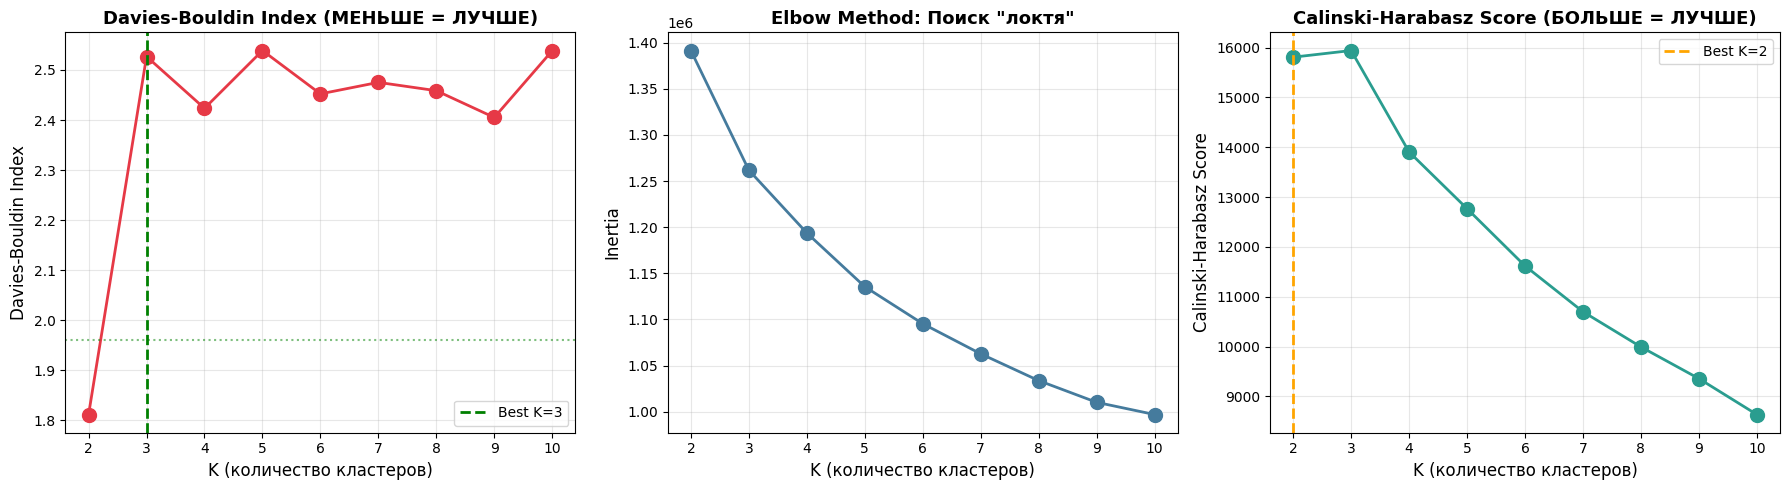


Интерпретация:
• Davies-Bouldin: K=3 (минимум = лучшее разделение)
• Calinski-Harabasz: K=2 (максимум = лучшее разделение)
• Elbow Method: 'Локоть' около K=3-4


In [17]:
df_results = pd.DataFrame(results)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# График 1: Davies-Bouldin (меньше = лучше)
axes[0].plot(df_results['K'], df_results['Davies_Bouldin'], 'o-', linewidth=2, markersize=10, color='#E63946')
axes[0].axvline(x=3, color='green', linestyle='--', linewidth=2, label='Best K=3')
axes[0].axhline(y=1.96, color='green', linestyle=':', alpha=0.5)
axes[0].set_xlabel('K (количество кластеров)', fontsize=12)
axes[0].set_ylabel('Davies-Bouldin Index', fontsize=12)
axes[0].set_title('Davies-Bouldin Index (МЕНЬШЕ = ЛУЧШЕ)', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()
axes[0].set_xticks(df_results['K'])

# График 2: Inertia (Elbow Method)
axes[1].plot(df_results['K'], df_results['Inertia'], 'o-', linewidth=2, markersize=10, color='#457B9D')
axes[1].set_xlabel('K (количество кластеров)', fontsize=12)
axes[1].set_ylabel('Inertia', fontsize=12)
axes[1].set_title('Elbow Method: Поиск "локтя"', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(df_results['K'])

# График 3: Calinski-Harabasz (больше = лучше)
axes[2].plot(df_results['K'], df_results['Calinski_Harabasz'], 'o-', linewidth=2, markersize=10, color='#2A9D8F')
axes[2].axvline(x=2, color='orange', linestyle='--', linewidth=2, label='Best K=2')
axes[2].set_xlabel('K (количество кластеров)', fontsize=12)
axes[2].set_ylabel('Calinski-Harabasz Score', fontsize=12)
axes[2].set_title('Calinski-Harabasz Score (БОЛЬШЕ = ЛУЧШЕ)', fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].legend()
axes[2].set_xticks(df_results['K'])

plt.tight_layout()
plt.show()

print("\nИнтерпретация:")
print("• Davies-Bouldin: K=3 (минимум = лучшее разделение)")
print("• Calinski-Harabasz: K=2 (максимум = лучшее разделение)")
print("• Elbow Method: 'Локоть' около K=3-4")

Распределение Gender внутри кластеров (%):
Depression      0      1
Cluster                 
0           48.75  51.25
1           74.14  25.86
2           96.34   3.66

Абсолютные числа:
Depression      0      1
Cluster                 
0            7180   7549
1           44782  15618
2           63171   2400


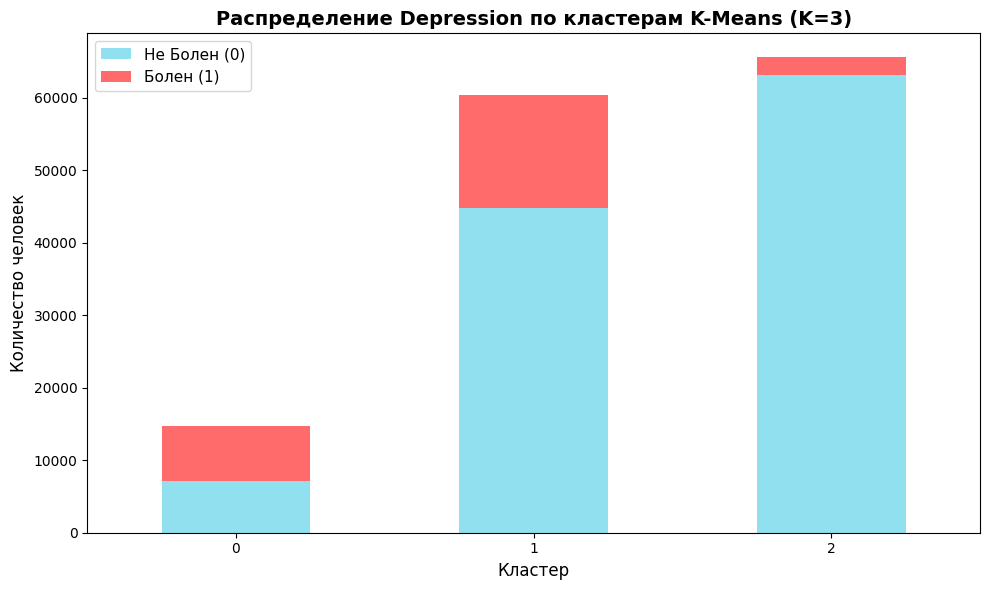

In [ ]:
crosstab_norm = pd.crosstab(df_train_clean['Cluster'], 
                            df_train_clean['Depression'], 
                            normalize='index')

print("Распределение Depression внутри кластеров (%):")
print((crosstab_norm * 100).round(2))

# Абсолютные числа
crosstab_abs = pd.crosstab(df_train_clean['Cluster'], 
                           df_train_clean['Depression'])
print("\nАбсолютные числа:")
print(crosstab_abs)

# Визуализация
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
crosstab_abs.plot(kind='bar', stacked=True, ax=ax, color=['#90E0EF', '#FF6B6B'])
ax.set_xlabel('Кластер', fontsize=12)
ax.set_ylabel('Количество человек', fontsize=12)
ax.set_title('Распределение Depression по кластерам K-Means (K=3)', fontsize=14, fontweight='bold')
ax.legend(['Не Болен (0)', 'Болен (1)'], fontsize=11)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.tight_layout()
plt.show()

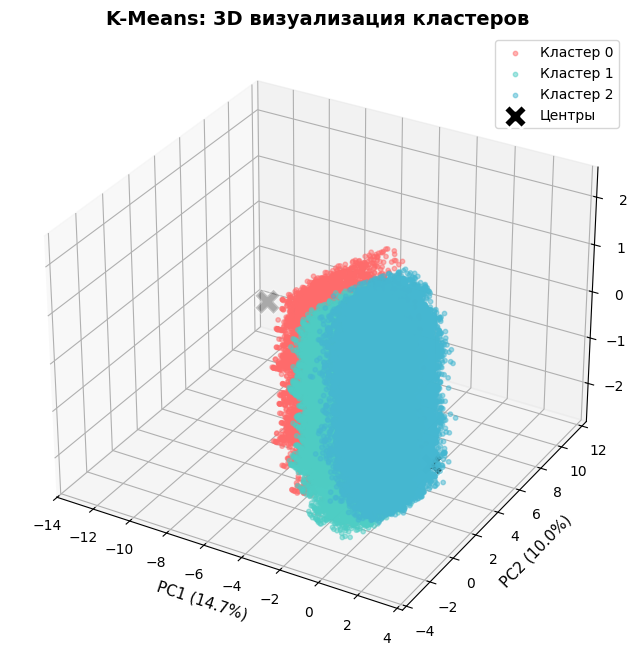

3 компоненты объясняют 34.1% дисперсии


In [19]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Стандартизируем данные (если еще не сделали)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA 3D
pca_3d = PCA(n_components=3, random_state=5)
X_pca_3d = pca_3d.fit_transform(X_scaled)

# Получаем центры кластеров из обученной модели
# Если ты использовал pipeline:
kmeans = pipeline.named_steps['kmeans']
centers_scaled = pipeline.named_steps['scaler'].transform(
    pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for cluster in range(3):
    mask = df_train_clean['Cluster'] == cluster
    ax.scatter(X_pca_3d[mask, 0], X_pca_3d[mask, 1], X_pca_3d[mask, 2],
              c=colors[cluster], label=f'Кластер {cluster}', 
              alpha=0.5, s=10)

centers_3d = pca_3d.transform(centers_scaled)
ax.scatter(centers_3d[:, 0], centers_3d[:, 1], centers_3d[:, 2],
          c='black', marker='X', s=300, label='Центры', edgecolors='white', linewidths=2)

ax.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
ax.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)
ax.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]*100:.1f}%)', fontsize=11)
ax.set_title('K-Means: 3D визуализация кластеров', fontsize=14, fontweight='bold')
ax.legend()
plt.show()

print(f"3 компоненты объясняют {pca_3d.explained_variance_ratio_.sum()*100:.1f}% дисперсии")

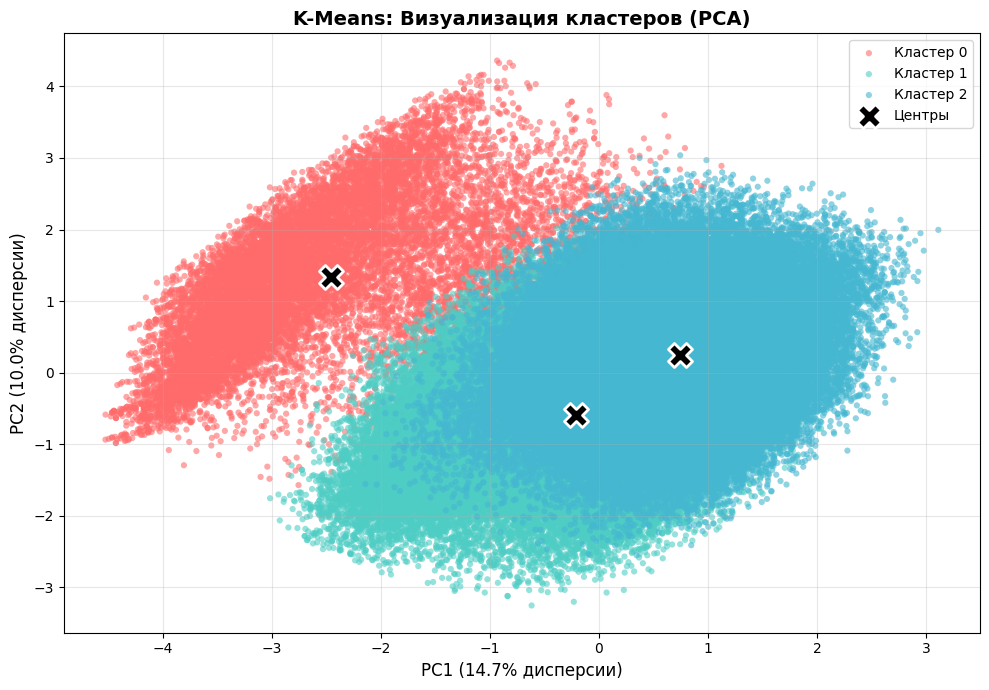

PCA объясняет 24.7% дисперсии


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# PCA: 11 признаков → 2 компоненты
pca = PCA(n_components=2, random_state=5)
X_pca = pca.fit_transform(X_scaled)

# Визуализация кластеров
plt.figure(figsize=(10, 7))

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
for cluster in range(3):
    mask = df_train_clean['Cluster'] == cluster
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               c=colors[cluster], 
               label=f'Кластер {cluster}', 
               alpha=0.6, s=20, edgecolors='none')

# Центры кластеров
centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], 
           c='black', marker='X', s=300, 
           edgecolors='white', linewidths=2,
           label='Центры', zorder=10)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% дисперсии)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% дисперсии)', fontsize=12)
plt.title('K-Means: Визуализация кластеров (PCA)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"PCA объясняет {pca.explained_variance_ratio_.sum()*100:.1f}% дисперсии")

### Промежуточные выводы по K-means

В ходе работы мы попробовали при random_state=5 использовать k от 2 до 10. Самым лучшим по метрикам оказался k=3 (по графику DB это заметно лучше всего). Также могли подойти k=2, k=4, k=5, если опираться на другие метрики. Для наглядности мы построили график распределения по таргет признаку, где первая группа - высокий уровень риска, затем средне-низкий и очень низкий уровень риска.

### DBSCAN

Для данного метода пришлось урезать количество строк, поскольку намертво ложился компьютер, даже при 20 потоках. Мы оставили только 10к данных и получили очень сильный дисбаланс кластеров. В коде не видно, но на деле мы перебирали куда большее количество параметров в грид сёрче, но в при любом раскладе всегда получался примерно 1 и тот же график. Немного шума, 1 очень большой кластер и 1 очень маленький. Возможно, неудачная выборка, возможно, не подходит для 11мерного пространства, но DBSCAN показал себя очень плохо.

DBSCAN ищет в нашем 11мерном пространстве скопления точек (отсюда и название "Кластеризация на основе плотности точек"). Выбирается центр и относительно него на расстоянии eps ищется min_samples точек, которые могли бы образовать кластер. Также выделяется отдельная группа - шум. Можно сравнить с поиском поселений на карте местности. Скопления домов в одном месте - вероятно, город или деревня. Отдельные дома посреди поля - выбросы, шум. 

Но в нашем 11мерном пространстве это проблематично, выделяется 1 огромный кластер. Или, еще хуже, 99% уходит в шум, а остальные раскидываются по очень мелким кластерам.

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# Перемешиваем данные и берём первые 10,000
df_shuffled = df_train_clean.sample(n=10000, random_state=5)

# Подготовка данных
X_sample = df_shuffled.drop(['Depression', 'Cluster', 'Cluster_DBSCAN'], axis=1)

# Стандартизация
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sample)

# DBSCAN
dbscan = DBSCAN(eps=2.0, min_samples=20, n_jobs=16)
dbscan.fit(X_scaled)

# Метки
df_shuffled['Cluster_DBSCAN'] = dbscan.labels_

print("DBSCAN на сэмпле завершён:")
print(df_shuffled['Cluster_DBSCAN'].value_counts().sort_index())
print(f"\nКластеров: {len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)}")
print(f"Шума: {(dbscan.labels_ == -1).sum()} ({(dbscan.labels_ == -1).sum()/len(df_shuffled)*100:.1f}%)")

DBSCAN на сэмпле завершён:
Cluster_DBSCAN
-1      764
 0     1149
 1     1280
 2     1111
 3     1157
 4     1008
 5     1244
 6     1051
 7      960
 8       91
 9       21
 10     115
 11      49
Name: count, dtype: int64

Кластеров: 12
Шума: 764 (7.6%)


In [37]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
import pandas as pd

results = []

eps_range = [2.0, 2.2, 2.4, 2.5, 2.6, 2.7,]
min_samples_range = [100, 200, 500]

for eps in eps_range:
    for min_samples in min_samples_range:
        print(f"eps={eps}, min_samples={min_samples}...", end=" ")
        
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=16)
        labels = dbscan.fit_predict(X_scaled)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = (labels == -1).sum()
        
        if n_clusters >= 2:
            mask = labels != -1
            if mask.sum() > 0:
                db_score = davies_bouldin_score(X_scaled[mask], labels[mask])
                ch_score = calinski_harabasz_score(X_scaled[mask], labels[mask])
            else:
                db_score = None
                ch_score = None
        else:
            db_score = None
            ch_score = None
        
        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_pct': n_noise / len(labels) * 100,
            'Davies_Bouldin': db_score,
            'Calinski_Harabasz': ch_score
        })
        
        print(f"Кластеров={n_clusters}, Шум={n_noise} ({n_noise/len(labels)*100:.1f}%)")

# Правильный выбор
df_results = pd.DataFrame(results)

valid = df_results[
    (df_results['n_clusters'] >= 2) & 
    (df_results['noise_pct'] < 30) &
    (df_results['Davies_Bouldin'].notna())
]

print("\n" + "="*60)
print("ВАЛИДНЫЕ КОМБИНАЦИИ (≥2 кластера, <30% шума):")
print("="*60)
print(valid.sort_values('Davies_Bouldin').to_string(index=False))

if len(valid) > 0:
    best = valid.loc[valid['Davies_Bouldin'].idxmin()]
    print(f"\n{'='*60}")
    print("ЛУЧШИЕ ПАРАМЕТРЫ:")
    print(f"{'='*60}")
    print(f"eps = {best['eps']}")
    print(f"min_samples = {best['min_samples']}")
    print(f"Кластеров: {int(best['n_clusters'])}")
    print(f"Шума: {int(best['n_noise'])} ({best['noise_pct']:.1f}%)")
    print(f"Davies-Bouldin: {best['Davies_Bouldin']:.4f}")

eps=2.0, min_samples=100... Кластеров=5, Шум=8393 (83.9%)
eps=2.0, min_samples=200... Кластеров=0, Шум=10000 (100.0%)
eps=2.0, min_samples=500... Кластеров=0, Шум=10000 (100.0%)
eps=2.2, min_samples=100... Кластеров=1, Шум=1906 (19.1%)
eps=2.2, min_samples=200... Кластеров=1, Шум=9298 (93.0%)
eps=2.2, min_samples=500... Кластеров=0, Шум=10000 (100.0%)
eps=2.4, min_samples=100... Кластеров=1, Шум=1031 (10.3%)
eps=2.4, min_samples=200... Кластеров=1, Шум=2213 (22.1%)
eps=2.4, min_samples=500... Кластеров=0, Шум=10000 (100.0%)
eps=2.5, min_samples=100... Кластеров=2, Шум=929 (9.3%)
eps=2.5, min_samples=200... Кластеров=1, Шум=1111 (11.1%)
eps=2.5, min_samples=500... Кластеров=0, Шум=10000 (100.0%)
eps=2.6, min_samples=100... Кластеров=2, Шум=788 (7.9%)
eps=2.6, min_samples=200... Кластеров=1, Шум=1029 (10.3%)
eps=2.6, min_samples=500... Кластеров=1, Шум=6301 (63.0%)
eps=2.7, min_samples=100... Кластеров=1, Шум=530 (5.3%)
eps=2.7, min_samples=200... Кластеров=1, Шум=1025 (10.2%)
eps=2.7, m

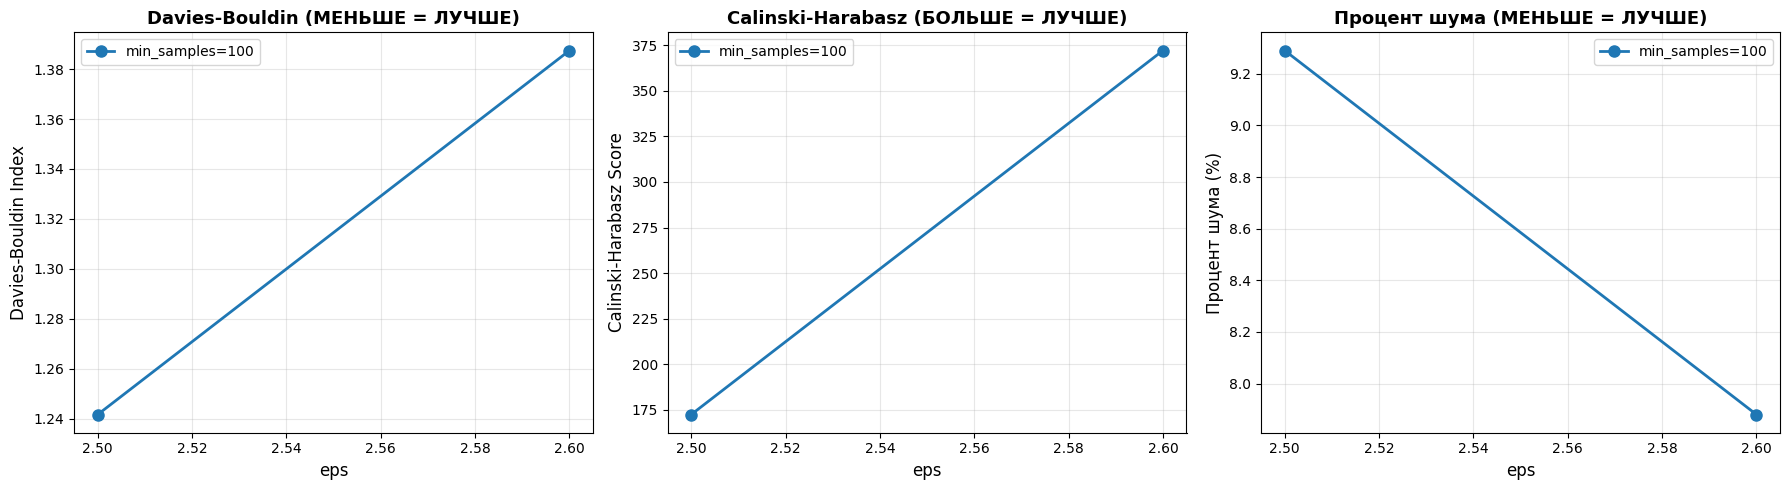

In [38]:
import matplotlib.pyplot as plt

valid = df_results[
    (df_results['n_clusters'] >= 2) & 
    (df_results['noise_pct'] < 30) &
    (df_results['Davies_Bouldin'].notna())
].copy()

valid_sorted = valid.sort_values(['eps', 'min_samples'])

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# График 1: Davies-Bouldin
for min_s in [50, 100, 200, 500]:
    subset = valid_sorted[valid_sorted['min_samples'] == min_s]
    if len(subset) > 0:
        axes[0].plot(subset['eps'], subset['Davies_Bouldin'], 
                    'o-', label=f'min_samples={min_s}', markersize=8, linewidth=2)

axes[0].set_xlabel('eps', fontsize=12)
axes[0].set_ylabel('Davies-Bouldin Index', fontsize=12)
axes[0].set_title('Davies-Bouldin (МЕНЬШЕ = ЛУЧШЕ)', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# График 2: Calinski-Harabasz
for min_s in [50, 100, 200, 500]:
    subset = valid_sorted[valid_sorted['min_samples'] == min_s]
    if len(subset) > 0:
        axes[1].plot(subset['eps'], subset['Calinski_Harabasz'], 
                    'o-', label=f'min_samples={min_s}', markersize=8, linewidth=2)

axes[1].set_xlabel('eps', fontsize=12)
axes[1].set_ylabel('Calinski-Harabasz Score', fontsize=12)
axes[1].set_title('Calinski-Harabasz (БОЛЬШЕ = ЛУЧШЕ)', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# График 3: Процент шума
for min_s in [50, 100, 200, 500]:
    subset = valid_sorted[valid_sorted['min_samples'] == min_s]
    if len(subset) > 0:
        axes[2].plot(subset['eps'], subset['noise_pct'], 
                    'o-', label=f'min_samples={min_s}', markersize=8, linewidth=2)

axes[2].set_xlabel('eps', fontsize=12)
axes[2].set_ylabel('Процент шума (%)', fontsize=12)
axes[2].set_title('Процент шума (МЕНЬШЕ = ЛУЧШЕ)', fontsize=13, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Распределение Depression внутри кластеров DBSCAN (%):
Depression          0      1
Cluster_DBSCAN              
-1              56.40  43.60
 0              85.63  14.37
 1               5.00  95.00

Абсолютные числа:
Depression         0     1
Cluster_DBSCAN            
-1               524   405
 0              7682  1289
 1                 5    95


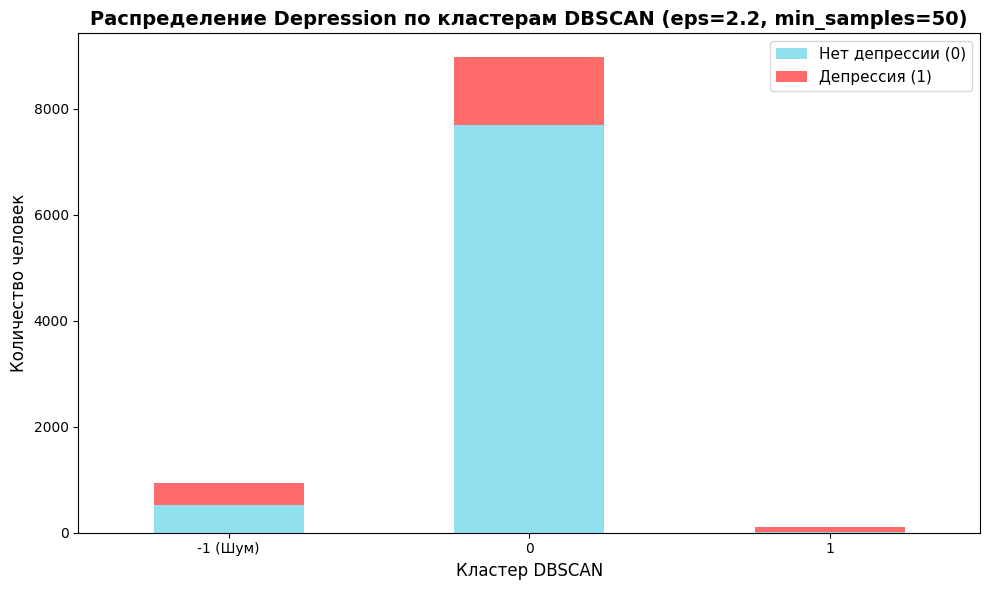

In [39]:
# Обучаем финальную DBSCAN модель с лучшими параметрами
dbscan_final = DBSCAN(eps=2.5, min_samples=100, n_jobs=16)
labels = dbscan_final.fit_predict(X_scaled)

df_shuffled['Cluster_DBSCAN'] = labels

# Кросс-таблица с процентами
crosstab_norm = pd.crosstab(df_shuffled['Cluster_DBSCAN'], 
                            df_shuffled['Depression'], 
                            normalize='index')

print("Распределение Depression внутри кластеров DBSCAN (%):")
print((crosstab_norm * 100).round(2))

# Абсолютные числа
crosstab_abs = pd.crosstab(df_shuffled['Cluster_DBSCAN'], 
                           df_shuffled['Depression'])
print("\nАбсолютные числа:")
print(crosstab_abs)

# Визуализация
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
crosstab_abs.plot(kind='bar', stacked=True, ax=ax, color=['#90E0EF', '#FF6B6B'])
ax.set_xlabel('Кластер DBSCAN', fontsize=12)
ax.set_ylabel('Количество человек', fontsize=12)
ax.set_title('Распределение Depression по кластерам DBSCAN (eps=2.2, min_samples=50)', fontsize=14, fontweight='bold')
ax.legend(['Нет депрессии (0)', 'Депрессия (1)'], fontsize=11)
ax.set_xticklabels(['-1 (Шум)', '0', '1'], rotation=0)
plt.tight_layout()
plt.show()

### Выводы
В ходе работы мы протестировали несколько методов кластеризации. Хорошо показал себя K-means, плохо - DBSCAN. Из-за опыта, полученного на DBSCAN мы отказались от идеи применять иерархическую кластеризацию, т к также пришлось бы уменьшать размер датасета и, вероятно, результат был бы таким же плохим. Специфика датасета не позволяет применить множество методов кластеризации.